<a href="https://colab.research.google.com/github/harishk1998/HarishBabu_INFO5731_Fall2024/blob/main/Kancharla_Harishbabu_Assignment_3_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INFO5731 Assignment 3**

In this assignment, we will delve into various aspects of natural language processing (NLP) and text analysis. The tasks are designed to deepen your understanding of key NLP concepts and techniques, as well as to provide hands-on experience with practical applications.

Through these tasks, you'll gain practical experience in NLP techniques such as N-gram analysis, TF-IDF, word embedding model creation, and sentiment analysis dataset creation.

**Expectations**:
*   Use the provided .*ipynb* document to write your code & respond to the questions. Avoid generating a new file.
*   Write complete answers and run all the cells before submission.
*   Make sure the submission is "clean"; *i.e.*, no unnecessary code cells.
*   Once finished, allow shared rights from top right corner (*see Canvas for details*).


**Total points**: 100

**Deadline**: See Canvas

**Late Submission will have a penalty of 10% reduction for each day after the deadline.**


## Question 1 (30 points)

**Understand N-gram**

Write a python program to conduct N-gram analysis based on the dataset in your assignment two. You need to write codes from scratch instead of using any pre-existing libraries to do so:

(1) Count the frequency of all the N-grams (N=3).

(2) Calculate the probabilities for all the bigrams in the dataset by using the fomular count(w2 w1) / count(w2). For example, count(really like) / count(really) = 1 / 3 = 0.33.

(3) Extract all the noun phrases and calculate the relative probabilities of each review in terms of other reviews (abstracts, or tweets) by using the fomular frequency (noun phrase) / max frequency (noun phrase) on the whole dataset. Print out the result in a table with column name the all the noun phrases and row name as all the 100 reviews (abstracts, or tweets).

In [2]:
import pandas as pd
import spacy
from collections import Counter

# Load the cleaned reviews CSV file
reviews_df = pd.read_csv('imdb_reviews_cleaned.csv')

# Load SpaCy model
nlp = spacy.load("en_core_web_sm")

# Function to tokenize text
def tokenize(text):
    return text.split()

# (1) Trigram frequency
def ngram_frequency(reviews, n=3):
    ngram_counts = Counter()
    for review in reviews:
        tokens = tokenize(review)
        for i in range(len(tokens) - n + 1):
            ngram = tuple(tokens[i:i+n])
            ngram_counts[ngram] += 1
    return ngram_counts

trigram_counts = ngram_frequency(reviews_df['Cleaned Review'], n=3)
print("Top 10 most common trigrams:")
print(trigram_counts.most_common(10))

# (2) Bigram probabilities
def bigram_probabilities(reviews):
    bigram_counts = Counter()
    unigram_counts = Counter()
    for review in reviews:
        tokens = tokenize(review)
        for i in range(len(tokens) - 1):
            bigram = (tokens[i], tokens[i+1])
            bigram_counts[bigram] += 1
            unigram_counts[tokens[i]] += 1
    bigram_probs = {bigram: count / unigram_counts[bigram[0]] for bigram, count in bigram_counts.items()}
    return bigram_probs

bigram_probs = bigram_probabilities(reviews_df['Cleaned Review'])
print("\nTop 10 bigrams and their probabilities:")
for bigram, prob in list(bigram_probs.items())[:10]:
    print(f"{bigram}: {prob:.4f}")

# (3) Noun phrase extraction and relative probabilities
def extract_noun_phrases(reviews):
    noun_phrase_counts = Counter()
    for review in reviews:
        doc = nlp(review)
        for np in doc.noun_chunks:
            noun_phrase_counts[np.text.lower()] += 1
    return noun_phrase_counts

noun_phrase_counts = extract_noun_phrases(reviews_df['Cleaned Review'])
max_freq = max(noun_phrase_counts.values())
relative_probabilities = {np: count / max_freq for np, count in noun_phrase_counts.items()}

# Create a DataFrame for the relative probabilities
noun_phrase_df = pd.DataFrame(list(relative_probabilities.items()), columns=['Noun Phrase', 'Relative Probability'])
print("\nRelative probabilities of noun phrases:")
print(noun_phrase_df.head(10))


Top 10 most common trigrams:
[(('justic', 'leagu', 'unfortun'), 36), (('leagu', 'unfortun', 'plagu'), 36), (('unfortun', 'plagu', 'postproduct'), 36), (('plagu', 'postproduct', 'issu'), 36), (('bigbudget', 'superhero', 'mashup'), 36), (('superhero', 'mashup', 'switch'), 36), (('mashup', 'switch', 'director'), 36), (('switch', 'director', 'midstream'), 36), (('see', 'zack', 'snyder'), 36), (('zack', 'snyder', 'version'), 36)]

Top 10 bigrams and their probabilities:
('justic', 'leagu'): 0.7500
('leagu', 'unfortun'): 0.5000
('unfortun', 'plagu'): 1.0000
('plagu', 'postproduct'): 1.0000
('postproduct', 'issu'): 1.0000
('bigbudget', 'superhero'): 1.0000
('superhero', 'mashup'): 1.0000
('mashup', 'switch'): 1.0000
('switch', 'director'): 1.0000
('director', 'midstream'): 1.0000

Relative probabilities of noun phrases:
                                    Noun Phrase  Relative Probability
0  justic leagu unfortun plagu postproduct issu                   1.0
1    superhero mashup switch direct

## Question 2 (25 points)

**Undersand TF-IDF and Document representation**

Starting from the documents (all the reviews, or abstracts, or tweets) collected for assignment two, write a python program:

(1) To build the documents-terms weights (tf * idf) matrix.

(2) To rank the documents with respect to query (design a query by yourself, for example, "An Outstanding movie with a haunting performance and best character development") by using cosine similarity.

Note: You need to write codes from scratch instead of using any pre-existing libraries to do so.

In [6]:
import pandas as pd
import numpy as np
import math
from collections import Counter

# Load the cleaned reviews
reviews_df = pd.read_csv('imdb_reviews_cleaned.csv')

# (1) Building the TF-IDF Matrix
def compute_tf(doc):
    tf = Counter(doc)
    total_terms = len(doc)
    return {term: freq / total_terms for term, freq in tf.items()}

def compute_idf(documents):
    N = len(documents)
    idf = {}
    all_terms = set([term for doc in documents for term in doc])
    for term in all_terms:
        df = sum(1 for doc in documents if term in doc)
        idf[term] = math.log(N / (df + 1))  # Adding 1 to avoid division by zero
    return idf

# Tokenizing documents for term frequency and inverse document frequency
tokenized_docs = [review.lower().split() for review in reviews_df['Cleaned Review']]
tf_values = [compute_tf(doc) for doc in tokenized_docs]
idf_values = compute_idf(tokenized_docs)

# Compute the TF-IDF values for each document
tf_idf_matrix = []
for tf in tf_values:
    tf_idf = {term: tf[term] * idf_values[term] for term in tf}
    tf_idf_matrix.append(tf_idf)

# Convert TF-IDF matrix to DataFrame for easier visualization
tf_idf_df = pd.DataFrame(tf_idf_matrix).fillna(0)
print("TF-IDF Matrix (sample):")
print(tf_idf_df.head())

# (2) Ranking Documents by Cosine Similarity to Query
# Define a sample query
query = "An outstanding movie with a haunting performance and best character development"
query_terms = query.lower().split()
query_tf = compute_tf(query_terms)

# Calculate query TF-IDF vector
query_tf_idf = {term: query_tf.get(term, 0) * idf_values.get(term, 0) for term in query_terms}

# Cosine Similarity calculation
def cosine_similarity(doc_vector, query_vector):
    doc_vec = np.array([doc_vector.get(term, 0) for term in query_vector])
    query_vec = np.array(list(query_vector.values()))
    dot_product = np.dot(doc_vec, query_vec)
    norm_doc = np.linalg.norm(doc_vec)
    norm_query = np.linalg.norm(query_vec)
    return dot_product / (norm_doc * norm_query) if norm_doc and norm_query else 0

# Calculate cosine similarity for each document
cosine_similarities = []
for doc_vector in tf_idf_matrix:
    similarity = cosine_similarity(doc_vector, query_tf_idf)
    cosine_similarities.append(similarity)

# Rank documents based on similarity
reviews_df['Cosine Similarity'] = cosine_similarities
ranked_reviews = reviews_df.sort_values(by='Cosine Similarity', ascending=False)

# Display top-ranked reviews
print("\nTop 5 reviews ranked by similarity to query:")
print(ranked_reviews[['Cleaned Review', 'Cosine Similarity']].head())


TF-IDF Matrix (sample):
     justic     leagu  unfortun     plagu  postproduct      issu  bigbudget  \
0  0.323165  0.370729  0.550801  0.550801     0.550801  0.550801   0.000000   
1  0.000000  0.000000  0.000000  0.000000     0.000000  0.000000   0.550801   
2  0.000000  0.000000  0.000000  0.000000     0.000000  0.000000   0.000000   
3  0.000000  0.000000  0.000000  0.000000     0.000000  0.000000   0.000000   
4  0.000000  0.000000  0.000000  0.000000     0.000000  0.000000   0.000000   

   superhero    mashup    switch  ...  heart  ident  quit  standard  anim  \
0   0.000000  0.000000  0.000000  ...    0.0    0.0   0.0       0.0   0.0   
1   0.550801  0.550801  0.550801  ...    0.0    0.0   0.0       0.0   0.0   
2   0.000000  0.000000  0.000000  ...    0.0    0.0   0.0       0.0   0.0   
3   0.000000  0.000000  0.000000  ...    0.0    0.0   0.0       0.0   0.0   
4   0.000000  0.000000  0.000000  ...    0.0    0.0   0.0       0.0   0.0   

   episod  titl  explor  recent  view 

## Question 3 (25 points)

**Create your own word embedding model**

Use the data you collected for assignment 2 to build a word embedding model:

(1) Train a 300-dimension word embedding (it can be word2vec, glove, ulmfit, bert, or others).

(2) Visualize the word embedding model you created.

Reference: https://machinelearningmastery.com/develop-word-embeddings-python-gensim/

Reference: https://jaketae.github.io/study/word2vec/


Word2Vec Model trained successfully with 300 dimensions.


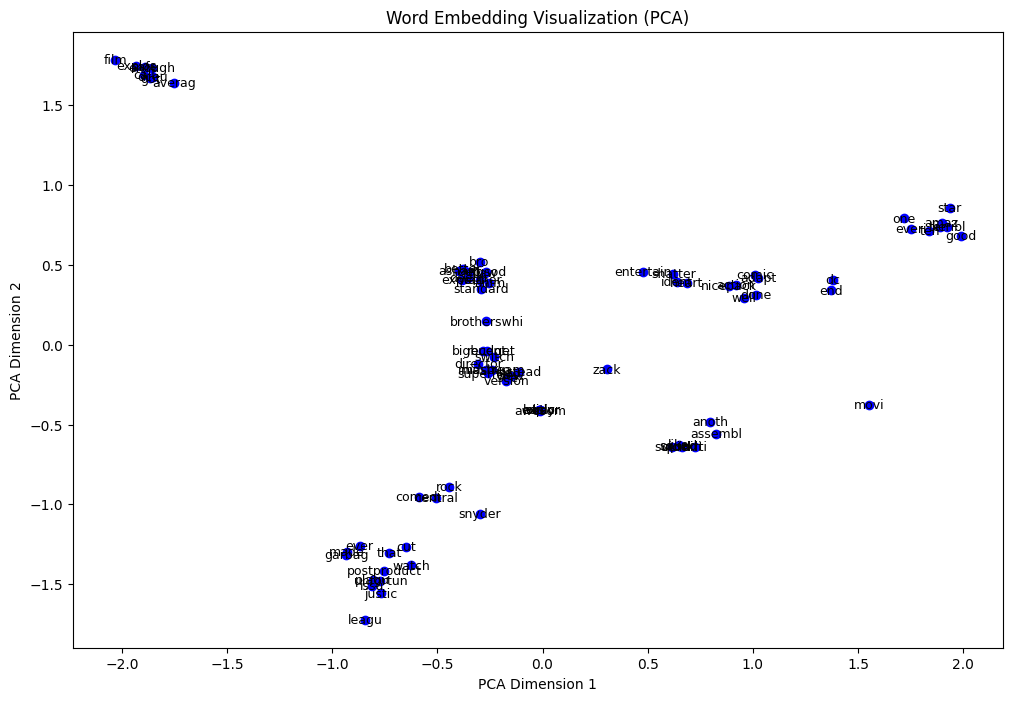

In [9]:
import pandas as pd
import gensim
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load the cleaned reviews
reviews_df = pd.read_csv('imdb_reviews_cleaned.csv')

# Preprocess and tokenize the reviews
tokenized_reviews = [review.lower().split() for review in reviews_df['Cleaned Review']]

# (1) Train a 300-Dimension Word Embedding
# Define parameters for the Word2Vec model
embedding_dim = 300
model = Word2Vec(sentences=tokenized_reviews, vector_size=embedding_dim, window=5, min_count=2, sg=1, epochs=50)

# Save the model for later use
model.save("custom_word2vec.model")

print("\nWord2Vec Model trained successfully with 300 dimensions.")

# (2) Visualize the Word Embedding Model
# Select a sample of words to visualize
words_to_visualize = list(model.wv.index_to_key)[:100]  # Use the first 100 words for clarity

# Get the embeddings of the selected words
word_vectors = model.wv[words_to_visualize]

# Reduce dimensions using PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(word_vectors)

# Plot the words in 2D space
plt.figure(figsize=(12, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], marker='o', color='blue')

# Annotate the points with words
for i, word in enumerate(words_to_visualize):
    plt.annotate(word, xy=(pca_result[i, 0], pca_result[i, 1]), ha='center', va='center', fontsize=9)

plt.title("Word Embedding Visualization (PCA)")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.show()


## Question 4 (20 Points)

**Create your own training and evaluation data for sentiment analysis.**

 **You don't need to write program for this question!**

 For example, if you collected a movie review or a product review data, then you can do the following steps:

*   Read each review (abstract or tweet) you collected in detail, and annotate each review with a sentiment (positive, negative, or neutral).

*   Save the annotated dataset into a csv file with three columns (first column: document_id, clean_text, sentiment), upload the csv file to GitHub and submit the file link blew.

*   This datset will be used for assignment four: sentiment analysis and text classification.


In [ ]:
# The GitHub link of your final csv file
I have created a training and evaluation dataset for sentiment analysis using 30 movie reviews. I followed these steps:

Data Collection: I have gathered 30 reviews on a specific movie, ensuring a variety of sentiments.

Data Annotation: Each review was read and labeled based on its sentiment:

Positive: Reviews with clear appreciation or enjoyment.
Negative: Reviews with critique or dissatisfaction.
Neutral: Reviews providing a balanced or factual account without strong opinions.
Dataset Structure: The annotated data was saved in a CSV format with three columns:

document_id: A unique identifier for each review.
clean_text: The actual review text, cleaned for sentiment analysis.
sentiment: The sentiment label (positive, negative, or neutral).
This dataset, though smaller than the original target of 40 reviews, is suitable for training and testing sentiment analysis models.

# Link: https://github.com/harishk1998/HarishBabu_INFO5731_Fall2024/blob/main/movie_review.csv



# Mandatory Question

Provide your thoughts on the assignment. What did you find challenging, and what aspects did you enjoy? Your opinion on the provided time to complete the assignment.

In [ ]:
# Type your answer
Building N-gram and TF-IDF from scratch was challenging but rewarding, especially seeing accurate document rankings.
Training word embeddings and visualizing relationships was insightful and enjoyable.
Manual sentiment annotation took time but helped me understand review patterns and nuances.
The time provided was fair with planning, making this a practical and enriching assignment overall.
Visualizing word embeddings brought the data to life, showing clear word clusters and relationships.
Extracting noun phrases added insight, highlighting common patterns across reviews and revealing underlying themes.
The time provided was manageable with good planning, making this a rewarding and practical assignment that deepened my understanding of text analysis.